In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv("drive/MyDrive/pca_reduced_dataset.csv")

In [2]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Target variable: Churn")
print(f"Class distribution:")
print(df['Churn'].value_counts())
print(f"Percentage distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)

Dataset shape: (7043, 15)
Features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14']
Target variable: Churn
Class distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Percentage distribution:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [3]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
xgb_basic = XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Handle class imbalance
)

print("Training Basic XGBoost...")
xgb_basic.fit(X_train, y_train)

Training Basic XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [5]:
y_pred_basic = xgb_basic.predict(X_test)
y_pred_proba_basic = xgb_basic.predict_proba(X_test)[:, 1]

# Calculate all metrics
accuracy_basic = accuracy_score(y_test, y_pred_basic)
precision_basic = precision_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic)
f1_basic = f1_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_pred_proba_basic)

print(f"PERFORMANCE METRICS - BASIC XGBOOST:")
print(f"Accuracy:  {accuracy_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"Recall:    {recall_basic:.4f}")
print(f"F1-Score:  {f1_basic:.4f}")
print(f"AUC-ROC:   {auc_basic:.4f}")


PERFORMANCE METRICS - BASIC XGBOOST:
Accuracy:  0.7573
Precision: 0.5333
Recall:    0.6845
F1-Score:  0.5995
AUC-ROC:   0.8270


In [6]:
cv_scores_basic = cross_val_score(xgb_basic, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_basic.mean():.4f} (+/- {cv_scores_basic.std() * 2:.4f})")

Cross-validation Accuracy: 0.7654 (+/- 0.0186)


CONFUSION MATRIX - BASIC XGBOOST:
[[811 224]
 [118 256]]


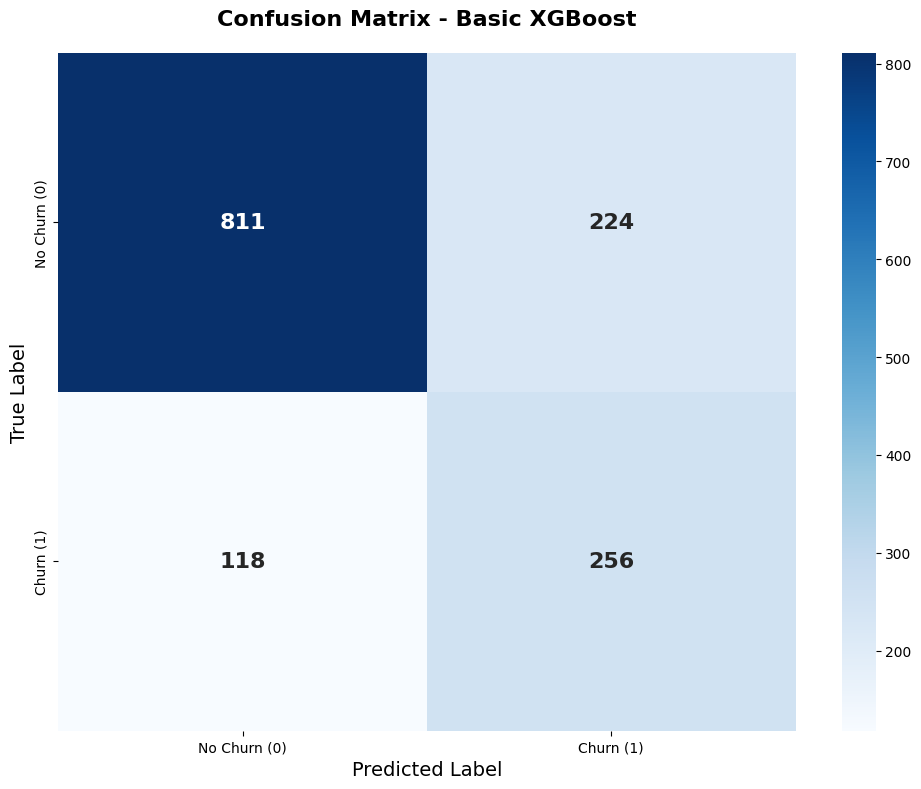

In [7]:
print(f"CONFUSION MATRIX - BASIC XGBOOST:")
cm_basic = confusion_matrix(y_test, y_pred_basic)
print(cm_basic)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Basic XGBoost', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
print(f"CLASSIFICATION REPORT - BASIC XGBOOST:")
print(classification_report(y_test, y_pred_basic, target_names=['No Churn', 'Churn']))

CLASSIFICATION REPORT - BASIC XGBOOST:
              precision    recall  f1-score   support

    No Churn       0.87      0.78      0.83      1035
       Churn       0.53      0.68      0.60       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



TOP 10 FEATURE IMPORTANCES - BASIC XGBOOST:
   Feature  Importance
1      PC2      0.2390
7      PC8      0.1108
0      PC1      0.0968
2      PC3      0.0745
9     PC10      0.0508
8      PC9      0.0508
12    PC13      0.0503
4      PC5      0.0494
6      PC7      0.0484
10    PC11      0.0478


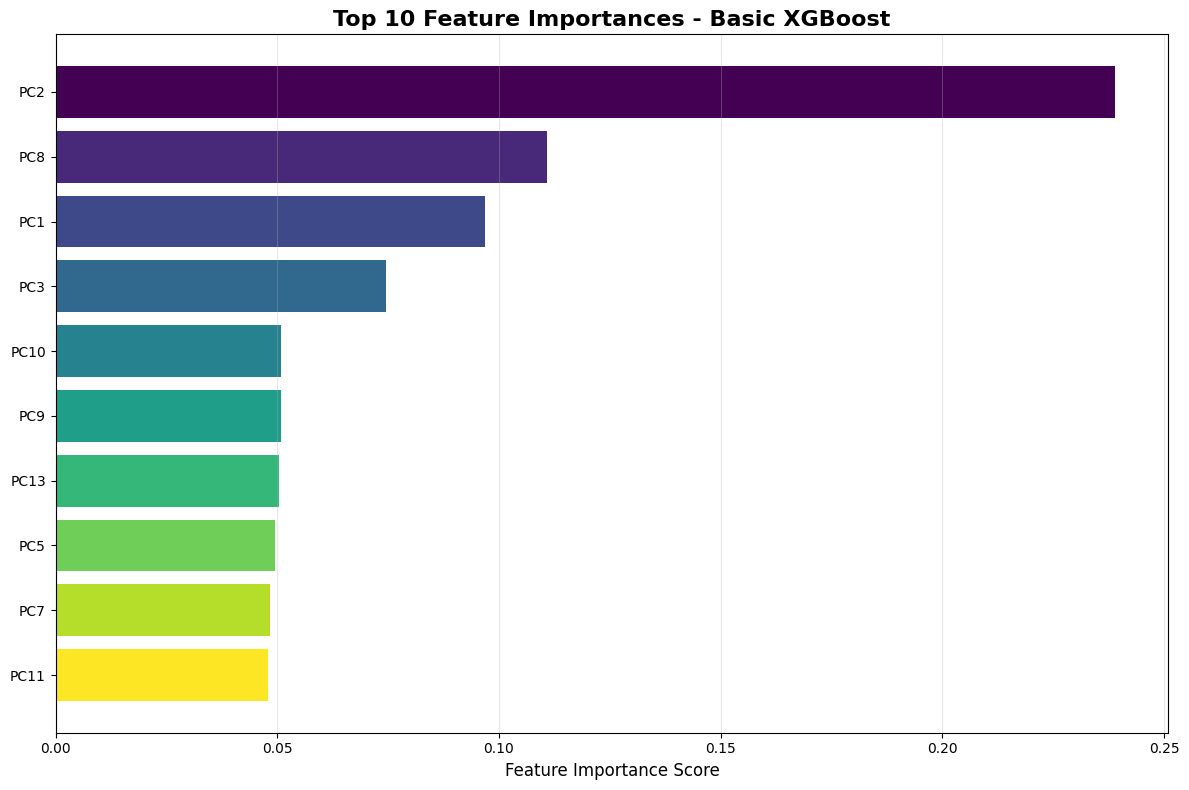

In [9]:
feature_importance_basic = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_basic.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"TOP 10 FEATURE IMPORTANCES - BASIC XGBOOST:")
print(feature_importance_basic.head(10).round(4))

plt.figure(figsize=(12, 8))
top_features_basic = feature_importance_basic.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features_basic)))
plt.barh(top_features_basic['Feature'], top_features_basic['Importance'], color=colors)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.title('Top 10 Feature Importances - Basic XGBoost', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Variety 2 - Hyperparameter tuned

In [10]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

print("Performing hyperparameter tuning with GridSearchCV...")
xgb_tuned = GridSearchCV(
    XGBClassifier(
        random_state=42,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
    ),
    param_grid_xgb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_tuned.fit(X_train, y_train)
print("Hyperparameter tuning completed!")

# Best parameters
print(f"BEST PARAMETERS FOUND:")
best_params_xgb = xgb_tuned.best_params_
for param, value in best_params_xgb.items():
    print(f"   {param}: {value}")
print(f"Best CV Score (F1): {xgb_tuned.best_score_:.4f}")

Performing hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Hyperparameter tuning completed!
BEST PARAMETERS FOUND:
   colsample_bytree: 0.9
   gamma: 0
   learning_rate: 0.01
   max_depth: 3
   n_estimators: 300
   subsample: 0.7
Best CV Score (F1): 0.6321


In [11]:
best_xgb_tuned = xgb_tuned.best_estimator_

# Make predictions with tuned model
y_pred_tuned = best_xgb_tuned.predict(X_test)
y_pred_proba_tuned = best_xgb_tuned.predict_proba(X_test)[:, 1]

# Calculate all metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"PERFORMANCE METRICS - TUNED XGBOOST:")
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")
print(f"AUC-ROC:   {auc_tuned:.4f}")


PERFORMANCE METRICS - TUNED XGBOOST:
Accuracy:  0.7459
Precision: 0.5140
Recall:    0.7861
F1-Score:  0.6216
AUC-ROC:   0.8451


In [12]:
cv_scores_tuned = cross_val_score(best_xgb_tuned, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_tuned.mean():.4f} (+/- {cv_scores_tuned.std() * 2:.4f})")


Cross-validation Accuracy: 0.7515 (+/- 0.0149)


CONFUSION MATRIX - TUNED XGBOOST:
[[757 278]
 [ 80 294]]


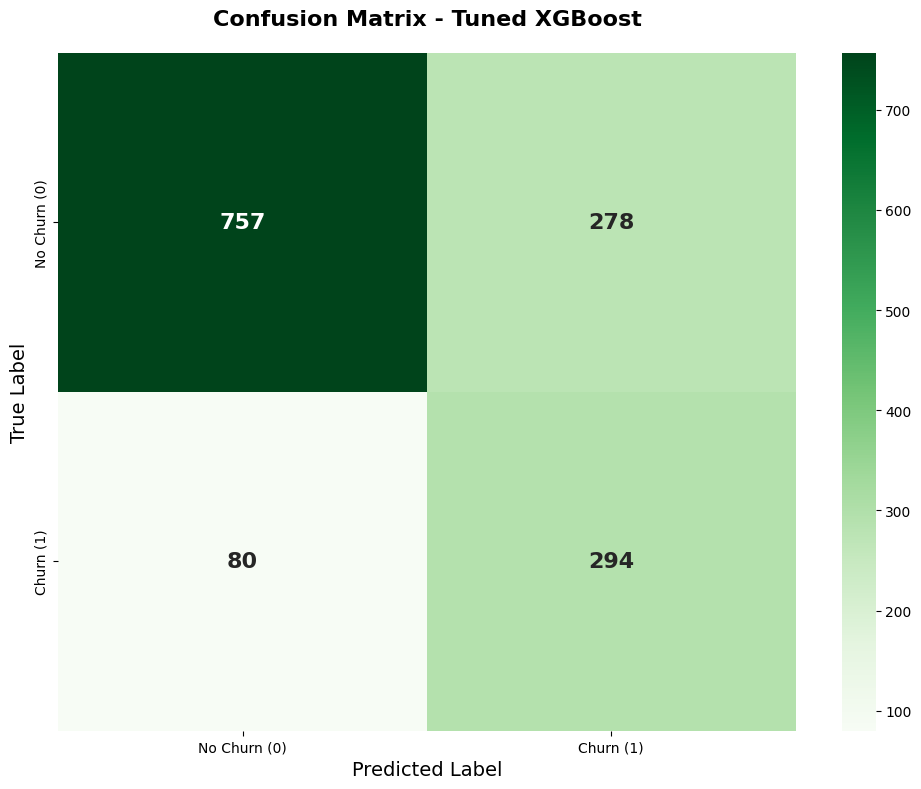

In [13]:
print(f"CONFUSION MATRIX - TUNED XGBOOST:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Tuned XGBoost', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
print(f"CLASSIFICATION REPORT - TUNED XGBOOST:")
print(classification_report(y_test, y_pred_tuned, target_names=['No Churn', 'Churn']))

CLASSIFICATION REPORT - TUNED XGBOOST:
              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.81      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



Variety 3 - Focused XGBoost(High precision)

In [15]:
xgb_focused = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=4,  # Shallower trees for less overfitting
    learning_rate=0.05,  # Lower learning rate for stability
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,  # Regularization
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) * 0.5  # Less emphasis on minority class for precision
)

print("Training Focused XGBoost (High Precision)...")
xgb_focused.fit(X_train, y_train)

Training Focused XGBoost (High Precision)...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
y_pred_focused = xgb_focused.predict(X_test)
y_pred_proba_focused = xgb_focused.predict_proba(X_test)[:, 1]

# Calculate all metrics
accuracy_focused = accuracy_score(y_test, y_pred_focused)
precision_focused = precision_score(y_test, y_pred_focused)
recall_focused = recall_score(y_test, y_pred_focused)
f1_focused = f1_score(y_test, y_pred_focused)
auc_focused = roc_auc_score(y_test, y_pred_proba_focused)

print(f"PERFORMANCE METRICS - FOCUSED XGBOOST:")
print(f"Accuracy:  {accuracy_focused:.4f}")
print(f"Precision: {precision_focused:.4f}")
print(f"Recall:    {recall_focused:.4f}")
print(f"F1-Score:  {f1_focused:.4f}")
print(f"AUC-ROC:   {auc_focused:.4f}")

PERFORMANCE METRICS - FOCUSED XGBOOST:
Accuracy:  0.7800
Precision: 0.5856
Recall:    0.5856
F1-Score:  0.5856
AUC-ROC:   0.8403


In [17]:
cv_scores_focused = cross_val_score(xgb_focused, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_focused.mean():.4f} (+/- {cv_scores_focused.std() * 2:.4f})")


Cross-validation Accuracy: 0.7943 (+/- 0.0161)


[[880 155]
 [155 219]]


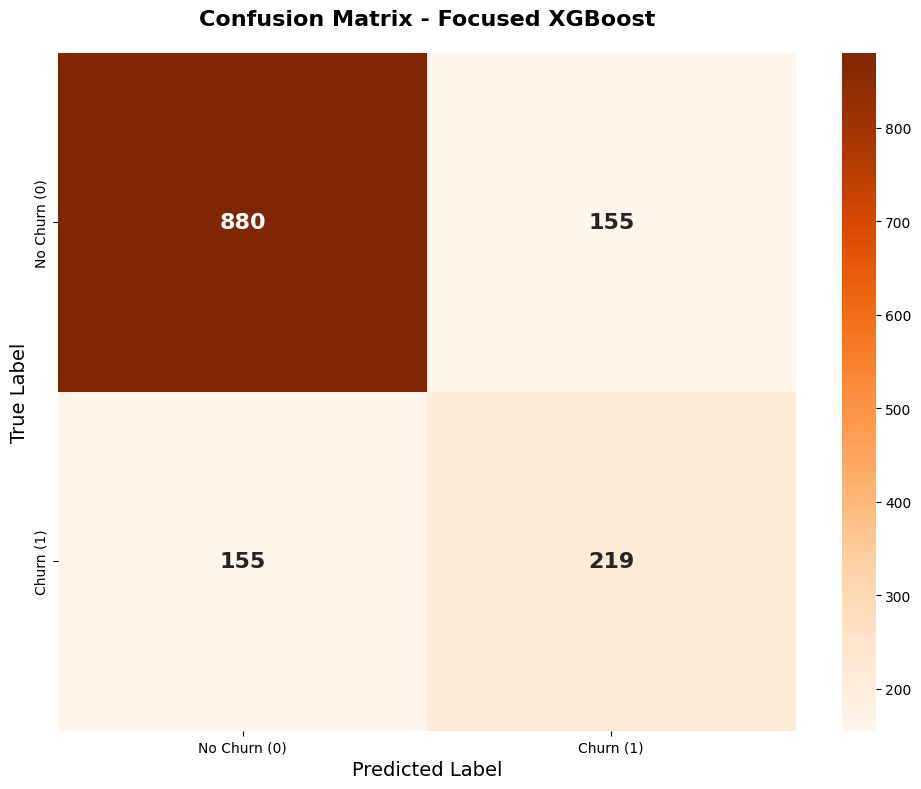

In [18]:
cm_focused = confusion_matrix(y_test, y_pred_focused)
print(cm_focused)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_focused, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Focused XGBoost', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
print(f"CLASSIFICATION REPORT - FOCUSED XGBOOST:")
print(classification_report(y_test, y_pred_focused, target_names=['No Churn', 'Churn']))

CLASSIFICATION REPORT - FOCUSED XGBOOST:
              precision    recall  f1-score   support

    No Churn       0.85      0.85      0.85      1035
       Churn       0.59      0.59      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [20]:
comparison_summary = pd.DataFrame({
    'Model': ['Basic XGBoost', 'Tuned XGBoost', 'Focused XGBoost'],
    'AUC_ROC': [auc_basic, auc_tuned, auc_focused],
    'Accuracy': [accuracy_basic, accuracy_tuned, accuracy_focused],
    'Precision': [precision_basic, precision_tuned, precision_focused],
    'Recall': [recall_basic, recall_tuned, recall_focused],
    'F1_Score': [f1_basic, f1_tuned, f1_focused],
    'CV_Accuracy': [cv_scores_basic.mean(), cv_scores_tuned.mean(), cv_scores_focused.mean()],
    'CV_Std': [cv_scores_basic.std(), cv_scores_tuned.std(), cv_scores_focused.std()]
})

print("\nCOMPREHENSIVE PERFORMANCE COMPARISON:")
print(comparison_summary.round(4))



COMPREHENSIVE PERFORMANCE COMPARISON:
             Model  AUC_ROC  Accuracy  Precision  Recall  F1_Score  \
0    Basic XGBoost   0.8270    0.7573     0.5333  0.6845    0.5995   
1    Tuned XGBoost   0.8451    0.7459     0.5140  0.7861    0.6216   
2  Focused XGBoost   0.8403    0.7800     0.5856  0.5856    0.5856   

   CV_Accuracy  CV_Std  
0       0.7654  0.0093  
1       0.7515  0.0075  
2       0.7943  0.0081  


In [22]:
best_auc_model = comparison_summary.loc[comparison_summary['AUC_ROC'].idxmax()]
best_f1_model = comparison_summary.loc[comparison_summary['F1_Score'].idxmax()]
best_precision_model = comparison_summary.loc[comparison_summary['Precision'].idxmax()]

print(f"\nBest model varient:")
print(f"Best AUC Score: {best_auc_model['Model']} (AUC: {best_auc_model['AUC_ROC']:.4f})")
print(f"Best F1-Score:  {best_f1_model['Model']} (F1: {best_f1_model['F1_Score']:.4f})")
print(f"Best Precision: {best_precision_model['Model']} (Precision: {best_precision_model['Precision']:.4f})")


Best model varient:
Best AUC Score: Tuned XGBoost (AUC: 0.8451)
Best F1-Score:  Tuned XGBoost (F1: 0.6216)
Best Precision: Focused XGBoost (Precision: 0.5856)


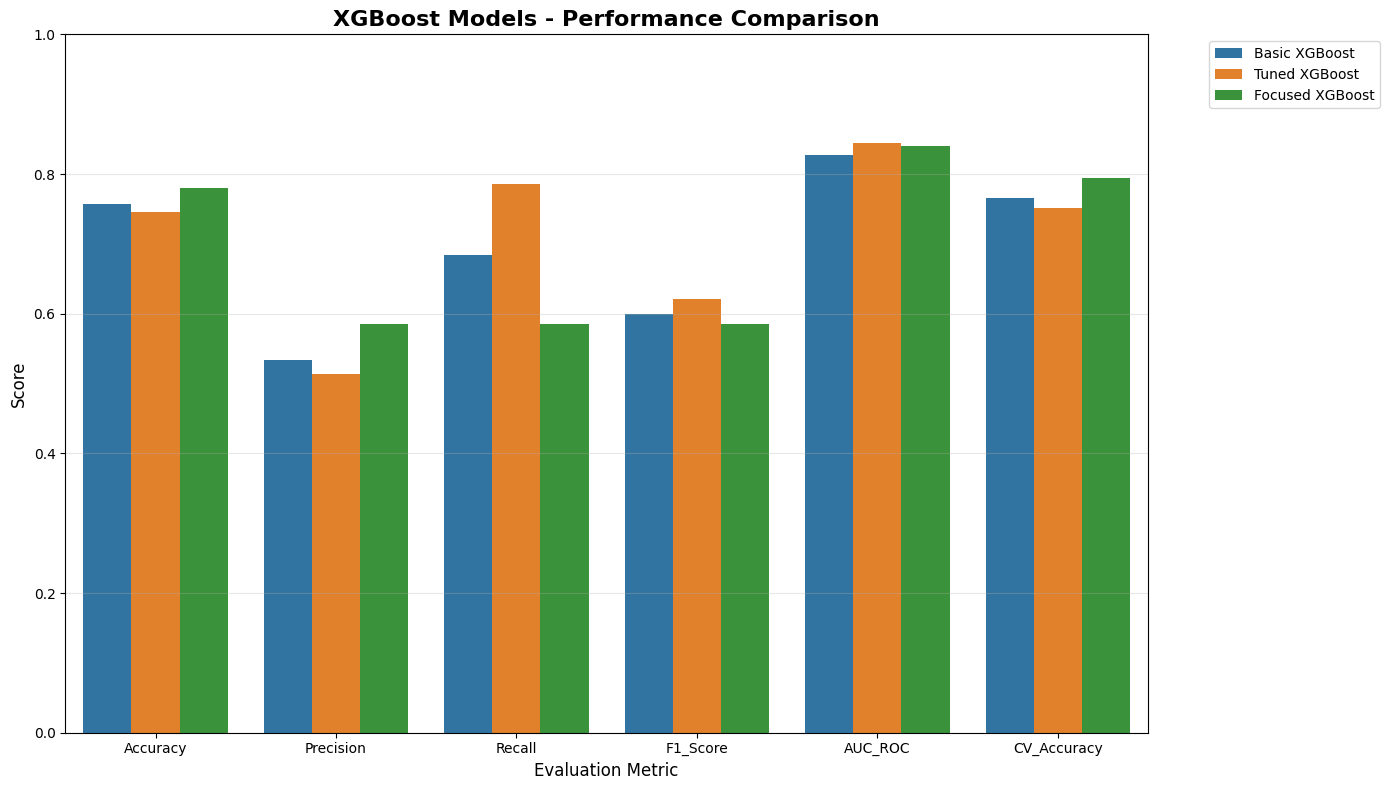

In [25]:
comparison_melted = comparison_summary.melt(
    'Model',
    var_name='Metric',
    value_name='Score',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC', 'CV_Accuracy']
)

# Create simple bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted)
plt.title('XGBoost Models - Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
print("BEST PERFORMING MODEL FOR EACH METRIC:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC', 'CV_Accuracy']:
    best_model = comparison_summary.loc[comparison_summary[metric].idxmax(), 'Model']
    best_score = comparison_summary[metric].max()
    print(f"   {metric}: {best_model} ({best_score:.4f})")

# Overall best model based on F1-Score (balanced metric)
best_overall = comparison_summary.loc[comparison_summary['F1_Score'].idxmax(), 'Model']
best_f1 = comparison_summary['F1_Score'].max()
print(f"\nOVERALL BEST MODEL: {best_overall}")
print(f"F1-Score: {best_f1:.4f}")

BEST PERFORMING MODEL FOR EACH METRIC:
   Accuracy: Focused XGBoost (0.7800)
   Precision: Focused XGBoost (0.5856)
   Recall: Tuned XGBoost (0.7861)
   F1_Score: Tuned XGBoost (0.6216)
   AUC_ROC: Tuned XGBoost (0.8451)
   CV_Accuracy: Focused XGBoost (0.7943)

OVERALL BEST MODEL: Tuned XGBoost
F1-Score: 0.6216
